In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

In [2]:
class Ex1Func(object):
    
    def __init__(self, sigma=lambda x: 0.5):
        self.sigma = sigma

    def __call__(self, x):
        
        if x[0] < 0.5:
            return x[0]**2. +  self.sigma(x[0]) * np.random.randn()
        if x[0] == 0.5:
            return 1.
        if x[0] > 0.5:
            return 2. - (x[0]-0.5) ** 2.

In [3]:
from pyDOE import *

/Users/piyushpandita/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


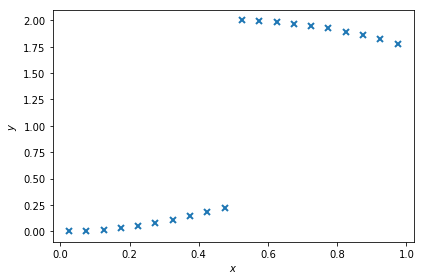

In [4]:
dim = 1
n = 20
noise=0
sigma = eval('lambda x: ' + str(noise))
objective = Ex1Func(sigma=sigma)
X = lhs(dim, n , criterion='center')
Y = np.array([objective(x) for x in X])[:, None]
Xnorm = (X - 0.5) / 0.5
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [55]:
#build the model
k = gpflow.kernels.RBF(input_dim=1)
noisekern = gpflow.kernels.RBF(input_dim=1, ARD=True)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale2D(Xnorm, Y, k, nonstat, noisekern)

In [56]:
m.kerns["ell0"].variance.prior = gpflow.priors.Gamma(1., 1.)
m.kerns["ell0"].lengthscales.prior = gpflow.priors.Gamma(1., 1.)
# m.likelihood.variance = 0.01
# m.likelihood.variance.fixed = True
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1., 1.)
m.noisekern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern2.variance.prior = gpflow.priors.Gamma(1., 1.)
# m.noisekern.variance.fixed = True
m.noisekern.variance.prior = gpflow.priors.Gamma(1., 1.)

In [57]:
m.optimize(maxiter=500) # start near MAP

      fun: array([9.4889788])
 hess_inv: <65x65 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.29901784e+02, -2.84360054e+02,  2.85164001e+01,  2.82365316e+01,
       -5.49819576e+00,  5.36486704e+00,  8.12413799e+00,  2.95199331e+00,
        7.30230849e+00, -1.71542631e+00,  1.37125027e-01, -2.44551509e+00,
       -9.14821900e-01, -2.34864402e-01,  1.55538097e+00,  9.45867593e-01,
       -4.13059788e+00, -3.79488464e+00, -4.49749505e-01,  2.24980591e+01,
        3.41229935e+00, -1.39686513e+00, -2.09413478e+00,  3.18674016e+00,
       -7.17008891e-01,  1.34741162e+00,  3.02264065e-01,  9.47944398e-01,
       -5.81408489e-01, -8.45766907e-02, -5.83180538e-02, -9.08609253e-02,
        6.35471356e-02,  2.18753894e-03, -7.28053321e-03,  3.59289417e-03,
       -8.40811719e-03, -5.83163916e-03, -1.22712011e-03,  4.19146559e-03,
       -3.26290118e+02, -9.30943673e+02,  8.43443333e+01,  2.02791716e+02,
        3.14226386e+02, -1.77319350e+02, -1.43698073e+02, -3.80140967e+01,
 

In [47]:
samples = m.sample(20, verbose=True, epsilon=0.00005, thin = 2, burn = 100, Lmax = 160)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
burn-in sampling ended


In [48]:
sample_df = m.get_samples_df(samples)
xnew = np.linspace(0, 1, 50)[:,None]
xx = (xnew - 0.5) / 0.5
mean_f_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))
mean_n_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))

In [49]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean_f, var_f = m.predict_f(xx)
    mean_f_mat[i, :] = mean_f[:, 0]
    var_f_mat[i, :] = np.diag(var_f)
    mean_n, var_n = m.predict_n(xx)
    mean_n_mat[i, :] = np.exp(mean_n[:, 0]) ** 2

In [50]:
std_f_mat = np.sqrt(var_f_mat)
Lowerf = mean_f_mat - 2 * std_f_mat
Upperf = mean_f_mat + 2 * std_f_mat

In [51]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Sd_noise = np.sqrt(noise_var) 
    Sd_epis = np.sqrt(Vargrid)
    
    lower = Mgrid - 2. * Sd_epis
    upper = Mgrid + 2. * Sd_epis
    
    lower1 = lower - 2. * Sd_noise
    upper1 = upper + 2. * Sd_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.05)
    plt.fill_between(Xgrid[:,0], lower1, upper1,
                    color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [52]:
X_true = np.linspace(0, 1, 100)[:,None]
Y_true = np.array([objective(x) for x in X_true])[:, None]

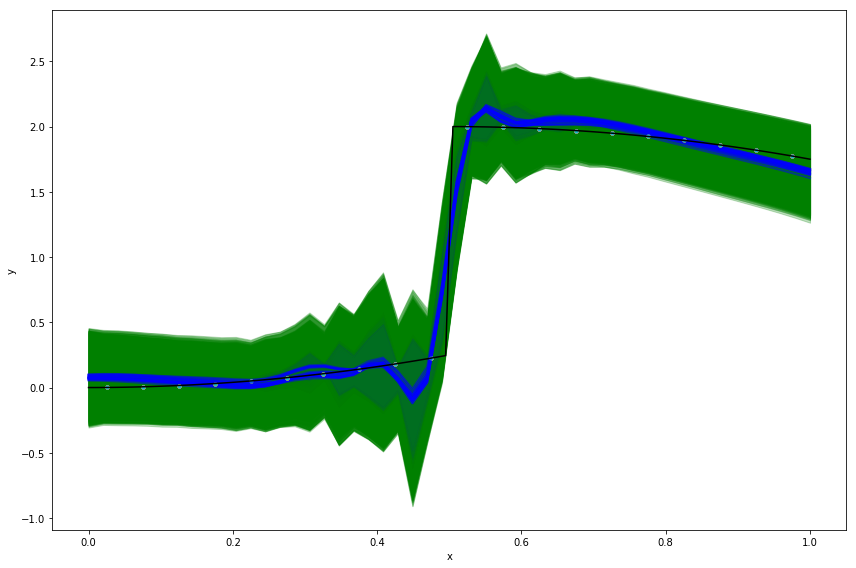

In [54]:
mini = 0
maxi = 20
plt.figure(figsize=(12, 8))

for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], var_f_mat[i,:], noise_var=mean_n_mat[i,:])  
plt.plot(X_true, Y_true, 'k')

In [25]:
print mean_n_mat, mean_f_mat

[[0.02824577 0.0275726  0.02693801 0.02634056 0.02577887 0.02525165
  0.02475767 0.02429579 0.02386492 0.02346406 0.02309227 0.02274867
  0.02243246 0.02214289 0.02187928 0.021641   0.02142749 0.02123826
  0.02107284 0.02093086 0.02081198 0.02071591 0.02064245 0.02059142
  0.0205627  0.02055624 0.02057203 0.02061011 0.02067058 0.02075361
  0.0208594  0.02098822 0.02114039 0.02131628 0.02151634 0.02174105
  0.02199097 0.02226671 0.02256894 0.02289842 0.02325593 0.02364235
  0.02405862 0.02450575 0.02498481 0.02549695 0.02604342 0.0266255
  0.02724458 0.02790214]
 [0.02826352 0.02758917 0.02695345 0.02635492 0.02579219 0.02526397
  0.02476902 0.02430621 0.02387445 0.02347273 0.02310011 0.02275571
  0.02243872 0.02214839 0.02188405 0.02164505 0.02143085 0.02124093
  0.02107485 0.02093221 0.02081268 0.02071599 0.0206419  0.02059024
  0.02056091 0.02055383 0.02056901 0.02060647 0.02066634 0.02074875
  0.02085392 0.02098211 0.02113364 0.02130889 0.02150829 0.02173234
  0.02198158 0.02225662 

In [ ]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [ ]:
mini = 100
maxi = 200
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_l(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [ ]:
m.predict_f_samples(xx, 100).shape